Epoka 0, Loss: 2.2713
Epoka 1000, Loss: 0.0077
Epoka 2000, Loss: 0.0028
Epoka 3000, Loss: 0.0012
Epoka 4000, Loss: 0.0013
Epoka 5000, Loss: 0.0010
Epoka 6000, Loss: 0.0006
Epoka 7000, Loss: 0.0006
Epoka 8000, Loss: 0.0005
Epoka 9000, Loss: 0.0006
Epoka 10000, Loss: 0.0005
Epoka 11000, Loss: 0.0004
Epoka 12000, Loss: 0.0003
Epoka 13000, Loss: 0.0003
Epoka 14000, Loss: 0.0004
Epoka 15000, Loss: 0.0003
Epoka 16000, Loss: 0.0002
Epoka 17000, Loss: 0.0002
Epoka 18000, Loss: 0.0002
Epoka 19000, Loss: 0.0002


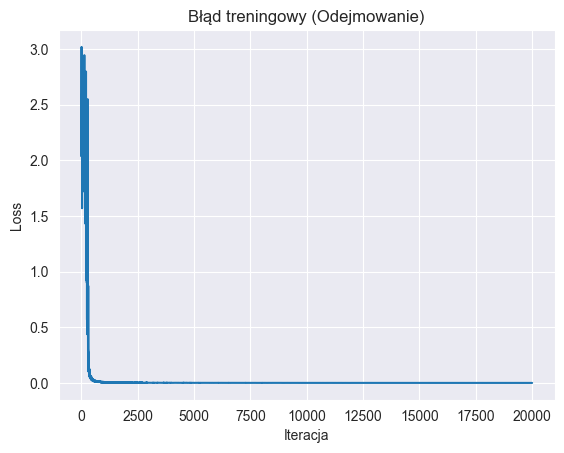


=== TESTOWANIE ===
Liczba A: 102318
Liczba B: 76981
Oczekiwany wynik (A - B): 25337
Wynik sieci (binarnie):   000110001011111001
Wynik sieci (decymalnie): 25337
Różnica: 0


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
BINARY_DIM = 18
INPUT_DIM = 2     # Bit A, Bit B
HIDDEN_DIM = 32   # Rozmiar stanu ukrytego
OUTPUT_DIM = 1    # Bit wyniku
LEARNING_RATE = 0.1
EPOCHS = 20000
BATCH_SIZE = 1

# Funkcje aktywacji
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def d_tanh(y):
    return 1 - y * y

# Generowanie danych (Odejmowanie 18-bitowe)
def generate_dataset(num_samples):
    max_val = 2**BINARY_DIM
    X = np.zeros((num_samples, BINARY_DIM, 2), dtype=int)
    Y = np.zeros((num_samples, BINARY_DIM, 1), dtype=int)

    for i in range(num_samples):
        # Losowanie liczb
        a_int = np.random.randint(0, max_val/2) # Mniejsze zakresy dla stabilności odejmowania w demo
        b_int = np.random.randint(0, max_val/2)

        # Zapewnienie a >= b dla uproszczenia (opcjonalnie można obsłużyć ujemne przez U2)
        if b_int > a_int:
            a_int, b_int = b_int, a_int

        c_int = a_int - b_int

        # Konwersja na binarny (odwrócone: LSB na indeksie 0)
        a_bin = np.array([int(x) for x in list(np.binary_repr(a_int, width=BINARY_DIM))])[::-1]
        b_bin = np.array([int(x) for x in list(np.binary_repr(b_int, width=BINARY_DIM))])[::-1]
        c_bin = np.array([int(x) for x in list(np.binary_repr(c_int, width=BINARY_DIM))])[::-1]

        X[i, :, 0] = a_bin
        X[i, :, 1] = b_bin
        Y[i, :, 0] = c_bin

    return X, Y, a_int, b_int, c_int # Zwracamy ostatnie liczby do podglądu

# Inicjalizacja wag
np.random.seed(42)
# Wagi wejście-ukryta
W_xh = np.random.uniform(-np.sqrt(1./INPUT_DIM), np.sqrt(1./INPUT_DIM), (INPUT_DIM, HIDDEN_DIM))
# Wagi ukryta-ukryta
W_hh = np.random.uniform(-np.sqrt(1./HIDDEN_DIM), np.sqrt(1./HIDDEN_DIM), (HIDDEN_DIM, HIDDEN_DIM))
# Wagi ukryta-wyjście
W_hy = np.random.uniform(-np.sqrt(1./HIDDEN_DIM), np.sqrt(1./HIDDEN_DIM), (HIDDEN_DIM, OUTPUT_DIM))

# Biasy
b_h = np.zeros((1, HIDDEN_DIM))
b_y = np.zeros((1, OUTPUT_DIM))

# Pętla treningowa
loss_history = []

for epoch in range(EPOCHS):
    # Generowanie jednej próbki (SGD)
    X, Y, _, _, _ = generate_dataset(BATCH_SIZE)
    x_seq = X[0] # Shape: [18, 2]
    y_target = Y[0] # Shape: [18, 1]

    # Przechowywanie stanów
    h_states = { -1: np.zeros((1, HIDDEN_DIM)) }
    outputs = []

    # Forward Pass
    loss = 0
    for t in range(BINARY_DIM):
        x_t = x_seq[t].reshape(1, INPUT_DIM)

        # Obliczenie stanu ukrytego
        h_raw = np.dot(x_t, W_xh) + np.dot(h_states[t-1], W_hh) + b_h
        h_t = tanh(h_raw)
        h_states[t] = h_t

        # Obliczenie wyjścia
        y_raw = np.dot(h_t, W_hy) + b_y
        y_pred = sigmoid(y_raw)
        outputs.append(y_pred)

        # Błąd dla kroku t
        loss += 0.5 * (y_target[t] - y_pred)**2

    loss_history.append(loss[0][0])

    # Backward Pass (BPTT)
    d_W_xh = np.zeros_like(W_xh)
    d_W_hh = np.zeros_like(W_hh)
    d_W_hy = np.zeros_like(W_hy)
    d_b_h = np.zeros_like(b_h)
    d_b_y = np.zeros_like(b_y)

    d_h_next = np.zeros((1, HIDDEN_DIM))

    for t in reversed(range(BINARY_DIM)):
        y_pred = outputs[t]
        y_true = y_target[t]

        # Gradient wyjścia
        error = y_pred - y_true
        d_y = error * d_sigmoid(y_pred)

        d_W_hy += np.dot(h_states[t].T, d_y)
        d_b_y += d_y

        # Gradient stanu ukrytego
        d_h = np.dot(d_y, W_hy.T) + d_h_next
        d_h_raw = d_h * d_tanh(h_states[t])

        d_W_xh += np.dot(x_seq[t].reshape(1, INPUT_DIM).T, d_h_raw)
        d_W_hh += np.dot(h_states[t-1].T, d_h_raw)
        d_b_h += d_h_raw

        d_h_next = np.dot(d_h_raw, W_hh.T)

    # Aktualizacja wag
    W_xh -= LEARNING_RATE * d_W_xh
    W_hh -= LEARNING_RATE * d_W_hh
    W_hy -= LEARNING_RATE * d_W_hy
    b_h -= LEARNING_RATE * d_b_h
    b_y -= LEARNING_RATE * d_b_y

    if epoch % 1000 == 0:
        print(f"Epoka {epoch}, Loss: {loss[0][0]:.4f}")

# Wizualizacja błędu
plt.plot(loss_history)
plt.title("Błąd treningowy (Odejmowanie)")
plt.xlabel("Iteracja")
plt.ylabel("Loss")
plt.show()

# Testowanie
print("\n=== TESTOWANIE ===")
X_test, Y_test, a_int, b_int, c_int = generate_dataset(1)
x_seq = X_test[0]

h_prev = np.zeros((1, HIDDEN_DIM))
pred_bits = []

for t in range(BINARY_DIM):
    x_t = x_seq[t].reshape(1, INPUT_DIM)
    h_t = tanh(np.dot(x_t, W_xh) + np.dot(h_prev, W_hh) + b_h)
    y_pred = sigmoid(np.dot(h_t, W_hy) + b_y)

    pred_bit = 1 if y_pred > 0.5 else 0
    pred_bits.append(pred_bit)
    h_prev = h_t

# Konwersja wyniku na int (odwracamy, bo LSB jest na indeksie 0)
res_bin_str = "".join(map(str, pred_bits[::-1]))
res_int = int(res_bin_str, 2)

print(f"Liczba A: {a_int}")
print(f"Liczba B: {b_int}")
print(f"Oczekiwany wynik (A - B): {c_int}")
print(f"Wynik sieci (binarnie):   {res_bin_str}")
print(f"Wynik sieci (decymalnie): {res_int}")
print(f"Różnica: {abs(c_int - res_int)}")